# 1) Importing necessary libraries

In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

# 2)Data Preprocessing

In [2]:
customers = pd.read_csv('C:/Users/srava/OneDrive/Desktop/Customers.csv')
transactions = pd.read_csv('C:/Users/srava/OneDrive/Desktop/Transactions.csv')

In [6]:
# Feature Engineering: Aggregate transaction data per customer
customer_data = transactions.groupby('CustomerID').agg(
    total_spending=('TotalValue', 'sum'),
    num_transactions=('TransactionID', 'nunique'),
    num_products=('ProductID', 'nunique')
).reset_index()

In [5]:
# Merge customer data with profile information from 'Customers.csv'
customer_profile = pd.merge(customers, customer_data, on='CustomerID', how='left')

In [14]:
# Scaling the Features
scaler = StandardScaler()
features = customer_profile[['total_spending', 'num_transactions', 'num_products']]

In [15]:
# Handling missing values
# Check if there are any missing values
print("Checking for missing values:")
print(features.isnull().sum())

Checking for missing values:
total_spending      1
num_transactions    1
num_products        1
dtype: int64


In [17]:
# Include 'CustomerID' in the features DataFrame
features_with_id = customer_profile[['CustomerID', 'total_spending', 'num_transactions', 'num_products']]

# Check for missing values and print the CustomerIDs with missing values
missing_data = features_with_id[features_with_id.isnull().any(axis=1)]  # Filter rows with missing values

# Display the CustomerID and corresponding missing values
print("Rows with missing values:")
print(missing_data[['CustomerID']])


Rows with missing values:
    CustomerID
179      C0180


In [20]:
# Drop rows with missing values if any
features_cleaned = features.dropna()

In [21]:
# Print the cleaned features dataset (before scaling)
print("Cleaned Features (before scaling):")
print(features_cleaned)

Cleaned Features (before scaling):
     total_spending  num_transactions  num_products
0           3354.52               5.0           5.0
1           1862.74               4.0           4.0
2           2725.38               4.0           4.0
3           5354.88               8.0           8.0
4           2034.24               3.0           3.0
..              ...               ...           ...
195         4982.88               4.0           3.0
196         1928.65               3.0           3.0
197          931.83               2.0           2.0
198         1979.28               4.0           4.0
199         4758.60               5.0           5.0

[199 rows x 3 columns]


In [23]:
#Check for missing values in the cleaned features
print("Checking for missing values in the cleaned features:")
print(features_cleaned.isnull().sum())

Checking for missing values in the cleaned features:
total_spending      0
num_transactions    0
num_products        0
dtype: int64


In [24]:
# Scaling the cleaned features
scaled_features = scaler.fit_transform(features_cleaned)

# 3)Clustering Algorithm

In [25]:
from sklearn.impute import SimpleImputer

# Impute missing values with the mean of each column
imputer = SimpleImputer(strategy='mean')
scaled_features_imputed = imputer.fit_transform(scaled_features)

# Now proceed with the KMeans clustering using the imputed data
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features_imputed)
    inertia.append(kmeans.inertia_)

In [26]:
print(inertia)

[245.89596805238068, 149.05189529056375, 127.22689622330915, 96.7413351145263, 81.52612468697495, 66.33850901427334, 64.4665018422557, 50.09050346633141, 46.98558978940306]


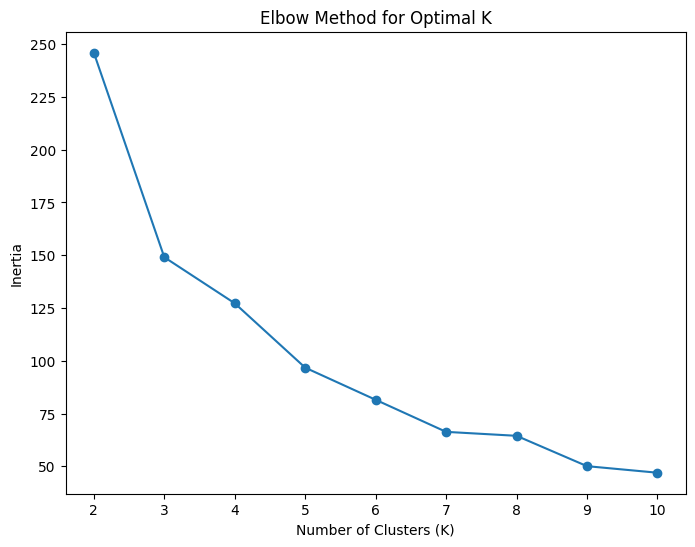

In [27]:
# Plot inertia for elbow method
plt.figure(figsize=(8,6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.show()

In [227]:
# Fit KMeans with number of clusters
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_features_imputed)

# Get the cluster labels for each customer
customer_profile = customer_profile.dropna() 
customer_profile['Cluster'] = kmeans.labels_

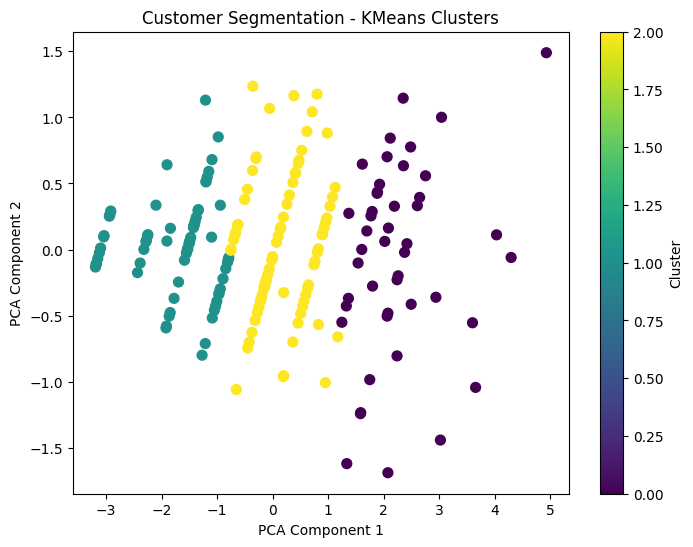

In [234]:
from sklearn.decomposition import PCA

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features_imputed)

# Add the PCA components to the customer profile DataFrame
customer_profile['PCA1'] = principal_components[:, 0]
customer_profile['PCA2'] = principal_components[:, 1]

# Plot the 2D scatter plot of the clusters
plt.figure(figsize=(8,6))
plt.scatter(customer_profile['PCA1'], customer_profile['PCA2'], c=customer_profile['Cluster'], cmap='viridis', s=50)
plt.title("Customer Segmentation - KMeans Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()


# 4)Davies-Bouldin Index(BDI)

In [229]:
from sklearn.metrics import davies_bouldin_score

# Calculate Davies-Bouldin Index for the clusters
db_index = davies_bouldin_score(scaled_features_imputed, kmeans.labels_)
print(f"DB Index: {db_index}")


DB Index: 0.763634176866093


# 5) Cluster Summary 

In [235]:
# Print the number of clusters and DB Index
print(f"Number of clusters formed: {optimal_k}")
print(f"DB Index value: {db_index}")

# Inspect the first few rows of the customer profile with cluster assignments
print(customer_profile.head())

Number of clusters formed: 3
DB Index value: 0.763634176866093
  CustomerID        CustomerName         Region  SignupDate  total_spending  \
0      C0001    Lawrence Carroll  South America  2022-07-10         3354.52   
1      C0002      Elizabeth Lutz           Asia  2022-02-13         1862.74   
2      C0003      Michael Rivera  South America  2024-03-07         2725.38   
3      C0004  Kathleen Rodriguez  South America  2022-10-09         5354.88   
4      C0005         Laura Weber           Asia  2022-08-15         2034.24   

   num_transactions  num_products  Cluster      PCA1      PCA2  
0               5.0           5.0        2 -0.010891 -0.068859  
1               4.0           4.0        1 -1.007066 -0.393343  
2               4.0           4.0        2 -0.749950  0.001715  
3               8.0           8.0        0  2.239951 -0.228860  
4               3.0           3.0        1 -1.507490  0.043896  


In [236]:
# Group by clusters and calculate mean statistics for each cluster
cluster_summary = customer_profile.groupby('Cluster').agg({
    'total_spending': 'mean',
    'num_transactions': 'mean',
    'num_products': 'mean'
}).reset_index()

print(cluster_summary)


   Cluster  total_spending  num_transactions  num_products
0        0     5624.359783          8.086957      7.739130
1        1     1769.641884          2.768116      2.695652
2        2     3680.591905          5.202381      5.142857
